**<h1 style="text-align: center;">Predição de preços de imóveis na Califórnia</h1>**


----------------------------------------------------------------

<img title="a title" alt="Alt text" src="https://i0.wp.com/calmatters.org/wp-content/uploads/2022/03/housing.jpg?fit=2263%2C1325&ssl=1">

Neste projeto, vamos utilizar técnicas de regressão linear com a biblioteca **scikit-learn** do **Python** para prever os preços de habitações na Califórnia. O objetivo é entender quais características de um imóvel residencial (como número de quartos, localização, renda da localidade etc.) influenciam o seu valor de mercado.

Para começarmos, é importante destacar que o conjunto de dados utilizado foi [retirado do Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices) e é referente ao **censo de 1990**. Utilizaremos técnicas de limpeza e pré-processamento dos dados para que eles estejam prontos para a análise.

Em seguida, vamos utilizar a **regressão linear** para modelar a relação entre as características da casa e o seu preço de mercado. Para avaliar a qualidade do modelo, vamos utilizar métricas como **R²** e **RMSE**.

Por fim, vamos analisar os resultados e entender quais características têm mais influência no preço de mercado das casas na Califórnia. Isso pode ser útil para profissionais do mercado imobiliário, investidores e até mesmo para pessoas que estão em busca de uma casa para comprar.

É importante salientar que, mesmo que o modelo seja baseado em dados históricos, ele pode ser útil para a tomada de decisão atual. Porém, é preciso estar ciente de que **há variáveis não contempladas no modelo, como a conjuntura econômica e política atual, que podem impactar nos preços das casas**.

## **Descrição dos dados**
#### Como está estruturado nosso *dataset* e quais são as variáveis?
----------------------------------------------------------------

O *dataset* que utilizaremos possui as seguintes variáveis:

- **`longitude`**: longitude de um determinado conjunto de casas.
- **`latitude`**: latitude de um determinado conjunto de casas.
- **`housing_median_age`**: idade mediana das casas em um quarteirão.
- **`total_rooms`**: total de quartos em um quarteirão de casas.
- **`total_bedrooms`**: total de quartos para dormir em um quarteirão.
- **`population`**: população da localidade em um quarteirão.
- **`households`**: número total de famílias, grupos de pessoas residindo em uma unidades domiciliar, por um quarteirão.
- **`median_income`**: renda mediana em um quarteirão.
- **`ocean_proximity`**: Proximidade com o oceano (menos de uma hora para chegar no oceano; terrestre; perto do oceano; perto de uma baía; em uma ilha).

## **Importação das bibliotecas e declaração de funções**
--------------------------------

In [2]:
%load_ext autoreload
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif, SelectKBest, RFECV
from feature_engine.selection import (
    SmartCorrelatedSelection,
    RecursiveFeatureElimination
)
from sklearn.decomposition import PCA

In [3]:
# conjunto de funções para facilitar análise de dados nulos e duplicados
def has_na(df: pd.DataFrame):
    return df.isna().sum()
def has_dupl(df: pd.DataFrame):
    return df.duplicated().sum()
def check_df(df: pd.DataFrame):
    print(f"[*] Checking for NA: \n{has_na(df)} \n\n[*] Duplicated: {has_dupl(df)}")

def get_na(df :pd.DataFrame): return df[df.isnull().any(axis=1)]

## **Entendendo os dados**
#### Tipos das variáveis e estatística descritiva
----------------------------------------------------------------

In [4]:
housing = pd.read_csv('data/housing.csv')
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [480]:
housing.columns = housing.columns.str.replace('latitude', 'lat')
housing.columns = housing.columns.str.replace('longitude', 'lon')

In [481]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lon                 20640 non-null  float64
 1   lat                 20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [482]:
check_df(housing)

[*] Checking for NA: 
lon                     0
lat                     0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64 

[*] Duplicated: 0


Aqui é possível perceber que a maioria das *features* iniciais são numéricas. Somente a proximidade com o oceano é um atributo categórico.

In [483]:
num_features = housing.select_dtypes('number')
cat_features = housing.drop(columns=num_features)

print(f'Variáveis numéricas: \n {num_features.columns.values}\n')
print(f'Variáveis categóricas: \n {cat_features.columns.values}')

Variáveis numéricas: 
 ['lon' 'lat' 'housing_median_age' 'total_rooms' 'total_bedrooms'
 'population' 'households' 'median_income' 'median_house_value']

Variáveis categóricas: 
 ['ocean_proximity']


In [484]:
housing.nunique().sort_values()

ocean_proximity           5
housing_median_age       52
lon                     844
lat                     862
households             1815
total_bedrooms         1923
median_house_value     3842
population             3888
total_rooms            5926
median_income         12928
dtype: int64

Não existe nenhumma coluna binária.

In [485]:
max_age = housing.housing_median_age.max()
min_age = housing.housing_median_age.min()

print(f"As idades medianas dos imóveis (das construções) estão entre {min_age} e {max_age} anos")

As idades medianas dos imóveis (das construções) estão entre 1.0 e 52.0 anos


In [486]:
max_value = housing.median_house_value.max()
min_value = housing.median_house_value.min()

print(f"Os preços medianos dos imóveis estão entre {min_value} e {max_value}")

Os preços medianos dos imóveis estão entre 14999.0 e 500001.0


In [487]:
housing.ocean_proximity.unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [488]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Resumo sobre as variáveis quantitativas:

In [489]:
housing.describe().drop(columns=['lon', 'lat']).T

,count,mean,std,min,25%,50%,75%,max
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


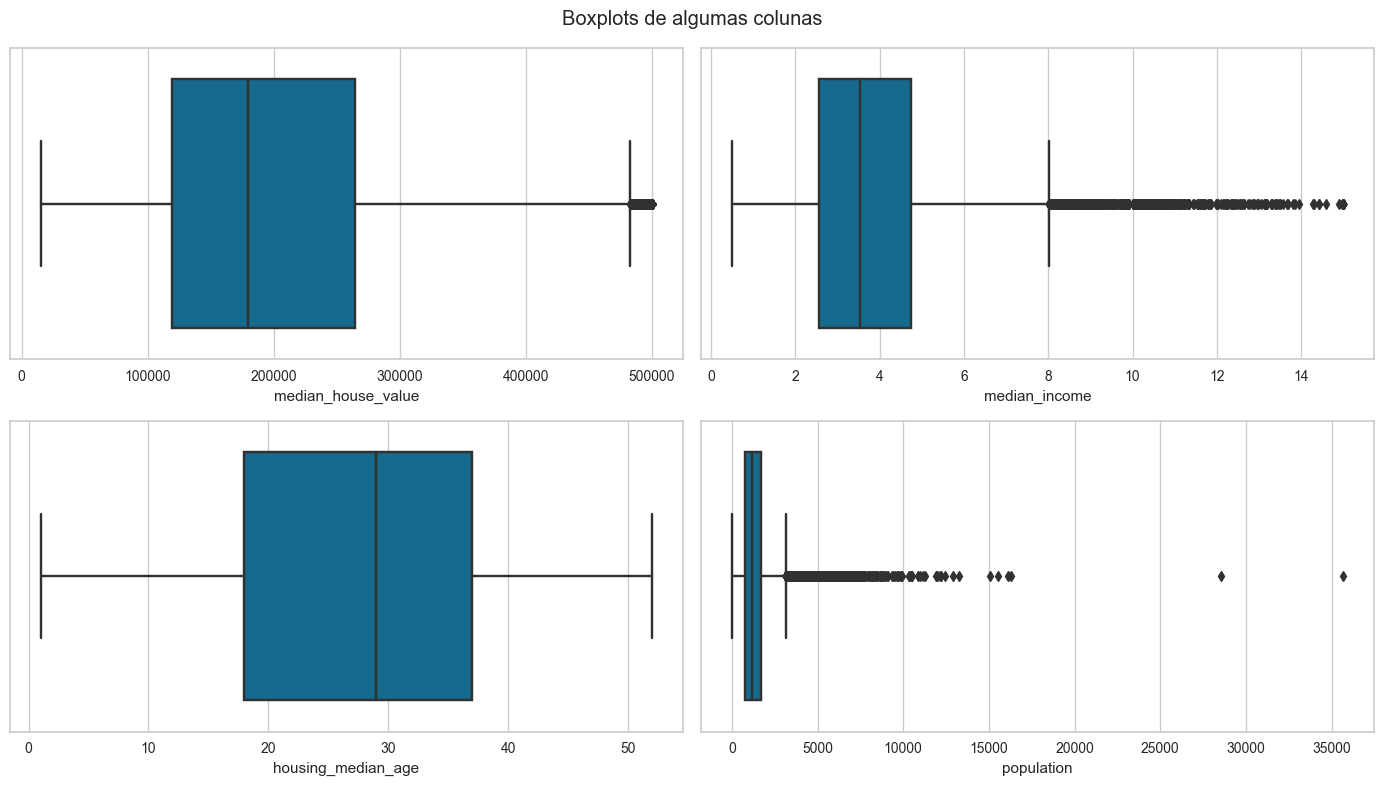

In [490]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

cols = ['median_house_value', 'median_income', 'housing_median_age', 'population']

for i, col in enumerate(cols):
    _ = sns.boxplot(data=housing, x=col, ax=axes[i])
fig.suptitle('Boxplots de algumas colunas')
fig.tight_layout()

Aqui, pode-se observar que a coluna `median_income` tem um número considerável de *outliers* e `population` possui bastante *outliers*.

Maiores preços:

In [491]:
housing.median_house_value.nlargest(10)

89     500001.0
459    500001.0
493    500001.0
494    500001.0
509    500001.0
510    500001.0
511    500001.0
512    500001.0
514    500001.0
517    500001.0
Name: median_house_value, dtype: float64

Maiores rendas:

In [492]:
housing.median_income.nlargest(10)

1566    15.0001
4352    15.0001
4604    15.0001
4605    15.0001
4606    15.0001
4626    15.0001
4678    15.0001
5242    15.0001
5247    15.0001
5248    15.0001
Name: median_income, dtype: float64

Aqui podemos perceber que provavelmente esses dois dados em um escala pré-determinada, isso é importante para que no futuro o algoritmo não aprenda erroneamente que existe um limite.

In [493]:
housing.query(f"median_income in {housing.median_income.nsmallest(3).to_list()} or population in {housing.population.nlargest(3).to_list()}")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
73,-122.29,37.81,46.0,12.0,4.0,18.0,7.0,0.4999,67500.0,NEAR BAY
3249,-119.99,36.09,23.0,333.0,92.0,198.0,55.0,0.4999,100000.0,INLAND
3258,-122.89,39.42,16.0,411.0,114.0,26.0,19.0,0.4999,73500.0,INLAND
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,500001.0,<1H OCEAN
5213,-118.28,33.93,52.0,117.0,33.0,74.0,45.0,0.4999,90600.0,<1H OCEAN
6343,-117.75,34.06,52.0,62.0,9.0,44.0,16.0,0.4999,112500.0,INLAND
6688,-118.08,34.15,28.0,238.0,58.0,142.0,31.0,0.4999,500001.0,INLAND
7125,-118.04,33.90,36.0,15.0,5.0,15.0,6.0,0.4999,162500.0,<1H OCEAN
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
13139,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND


Podemos ver que há lugares em que o preço mediano é bem **alto** mas a renda é **baixa**.

In [494]:
housing.query("total_bedrooms > total_rooms")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity


Não faz sentido ter mais quartos para dormir do que quartos totais.

In [495]:
housing.query("households > population")

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5342,-118.44,34.04,16.0,18.0,6.0,3.0,4.0,0.5360,350000.0,<1H OCEAN
11849,-121.00,39.75,8.0,1116.0,214.0,27.0,39.0,2.5893,83000.0,INLAND
19522,-121.00,37.65,17.0,484.0,202.0,198.0,204.0,0.6825,187500.0,INLAND


## **Análise exploratória (EDA)**
#### Analisando, investigando os dados e descrevendo suas principais características.
----------------------------------------------------------------

### Análise univariada

#### *Features* numéricas

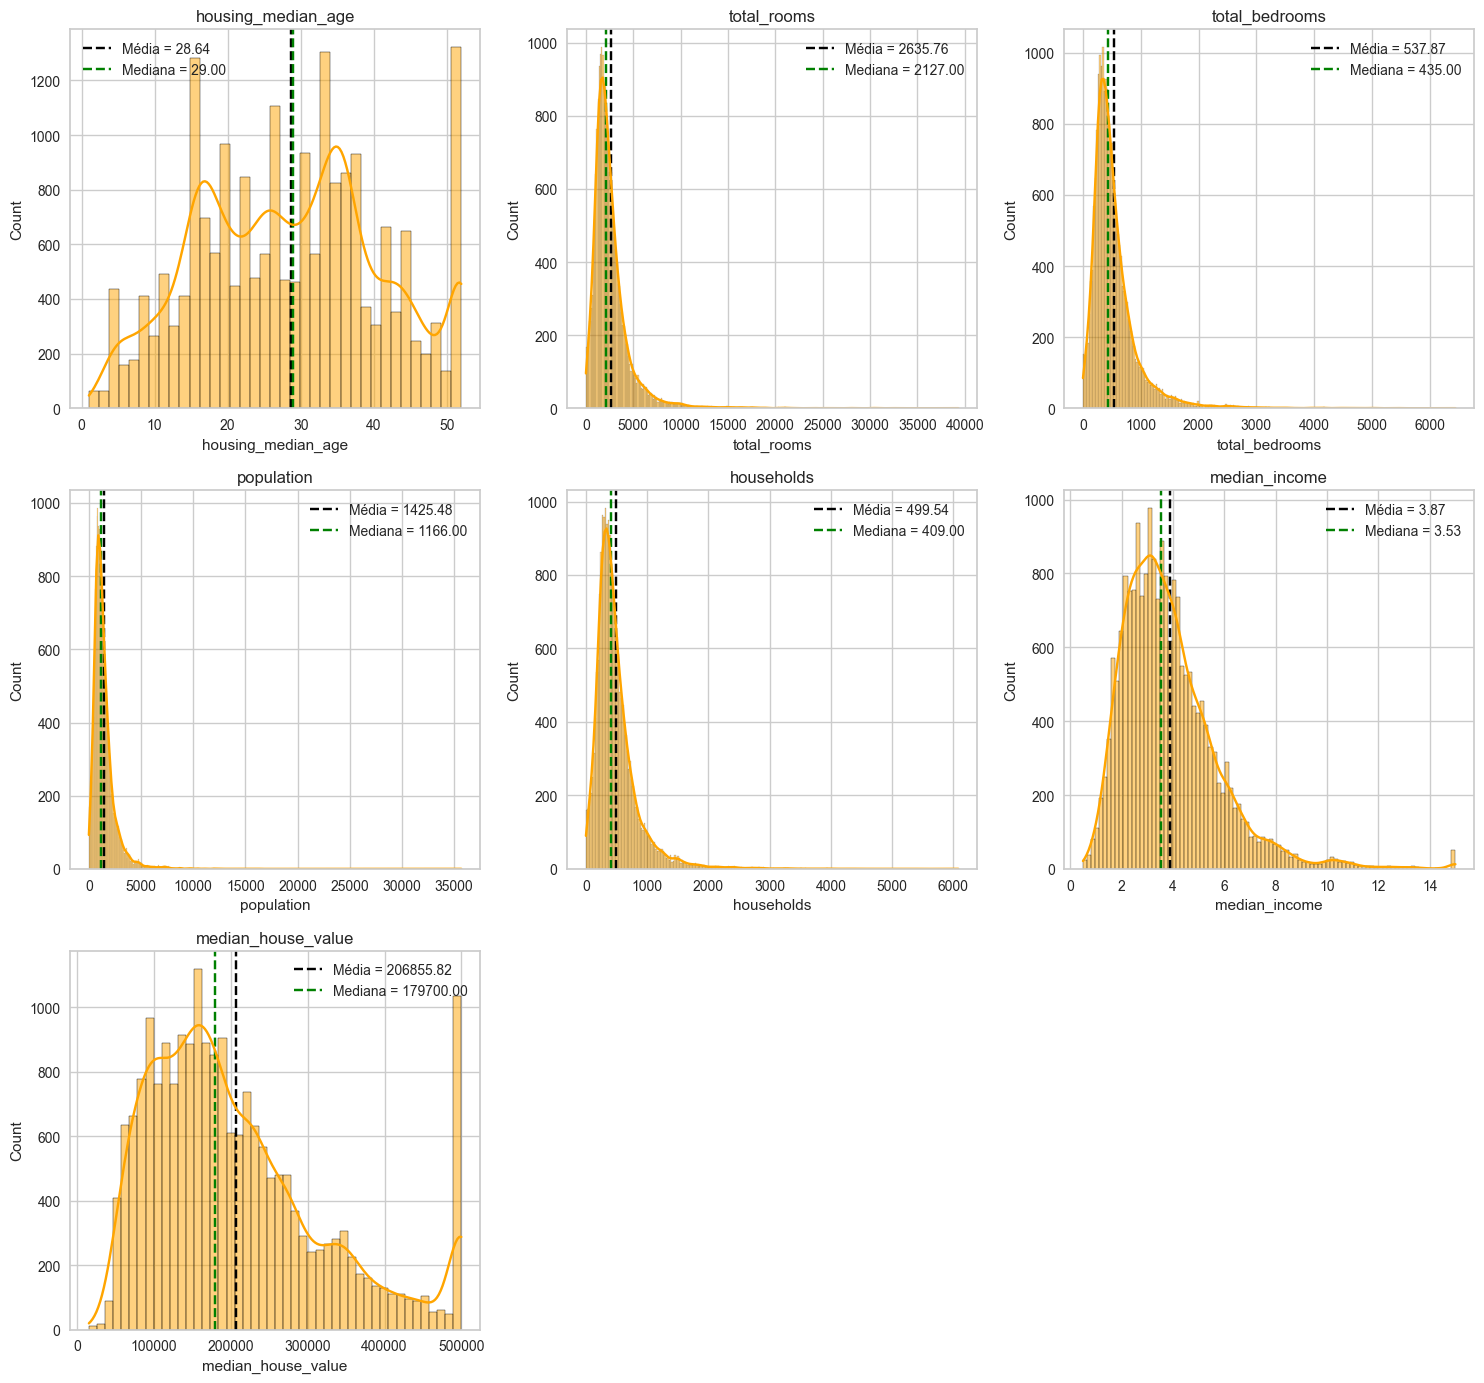

In [496]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 14))
axes = axes.flatten()

for i, column in enumerate(num_features.drop(columns=['lat', 'lon'])):
    mean_val = housing[column].mean()
    median_val = housing[column].median()
    axes[i].axvline(mean_val, color='black', linestyle='--', label=f'Média = {mean_val:.2f}')
    axes[i].axvline(median_val, color='green', linestyle='--', label=f'Mediana = {median_val:.2f}')

    axes[i].legend()


    sns.histplot(data=housing,x=column, ax=axes[i], kde=True, color='orange')
    axes[i].set_title(column)

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.tight_layout()

A grande maioria das colunas são *right-skewed* (possuem assimetria à direita), indicando que a **média é maior que a mediana**. Nesses casos a **mediana** captura melhor os valores que mais aparecem.

Podemos ver também que há um valor anormal de imóveis com preço ao redor de 500 mil (na coluna `median_house_value`), como observado anteriormente.

#### *Feature* categórica

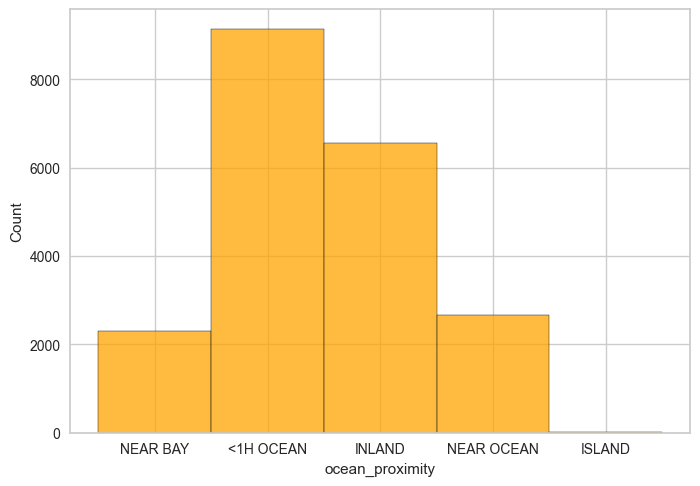

In [497]:
_ = sns.histplot(data=cat_features, x='ocean_proximity', color='orange')

A tendência são casas com menos de uma hora de distância do mar.

### Análise bivariada

In [498]:
housing.columns

Index(['lon', 'lat', 'housing_median_age', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'median_income', 'median_house_value',
       'ocean_proximity'],
      dtype='object')

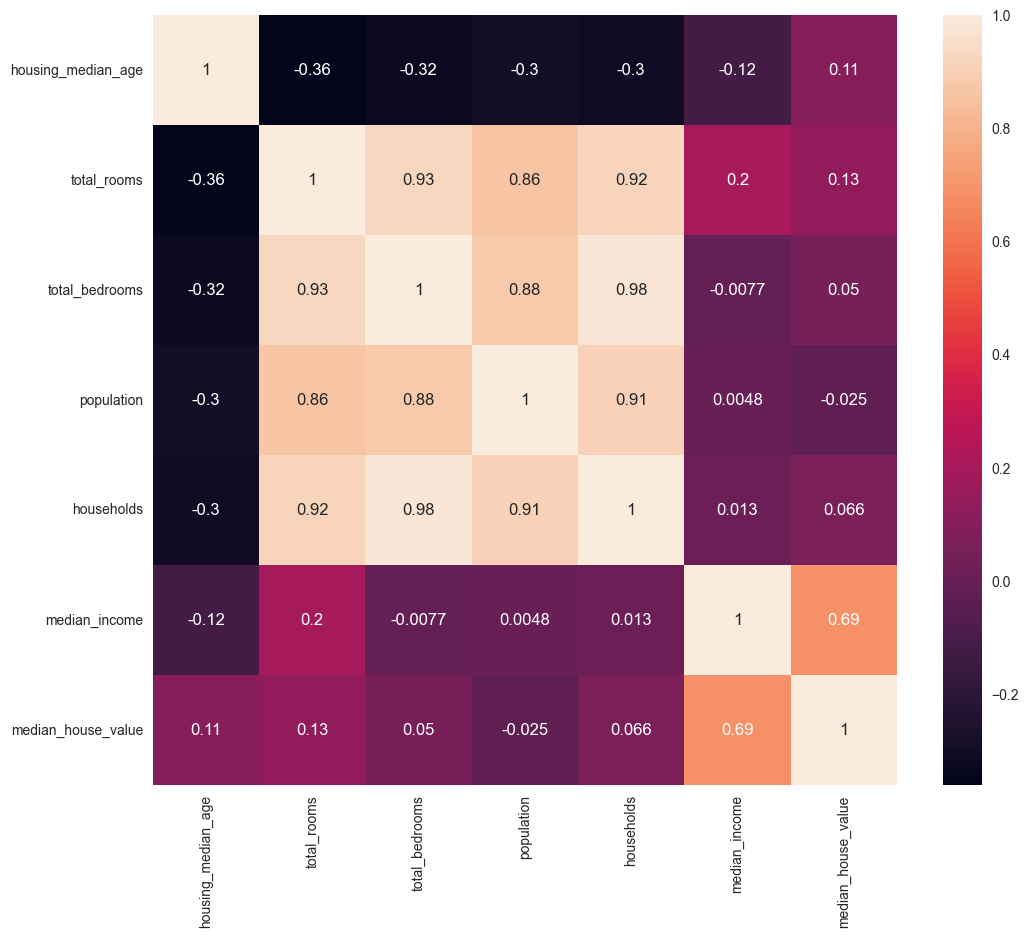

In [499]:
_ = plt.figure(figsize=(12, 10))
_ = sns.heatmap(housing.drop(columns=['lat','lon']).corr(), annot=True)

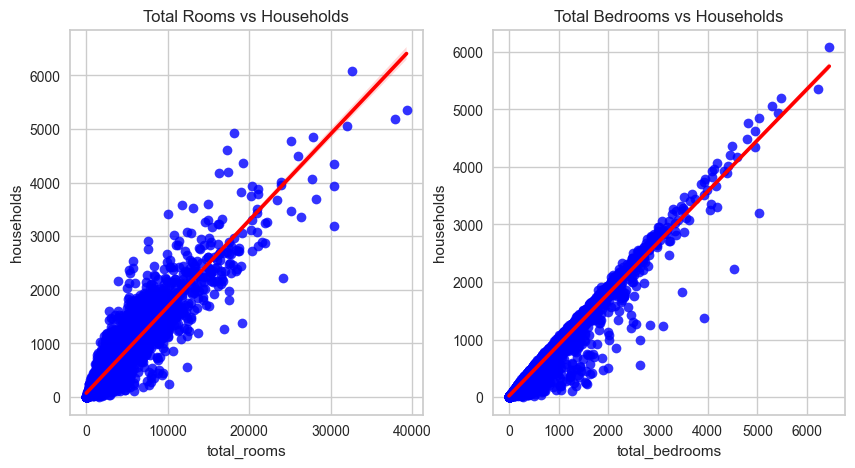

In [500]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
_ = sns.regplot(data=housing, x='total_rooms', y='households', scatter_kws={"color": "blue", "edgecolor":"k" },
           line_kws={"color": "red"}, ax=axes[0])
_ = axes[0].set_title('Total Rooms vs Households')
_ = sns.regplot(data=housing, x='total_bedrooms', y='households', scatter_kws={"color": "blue", "edgecolor":"k"},
           line_kws={"color": "red"}, ax=axes[1])
_ = axes[1].set_title('Total Bedrooms vs Households')


Aparentemente há uma relação linear bem forte entre lares e quartos

#### Onde estão as concentrações de imóveis?

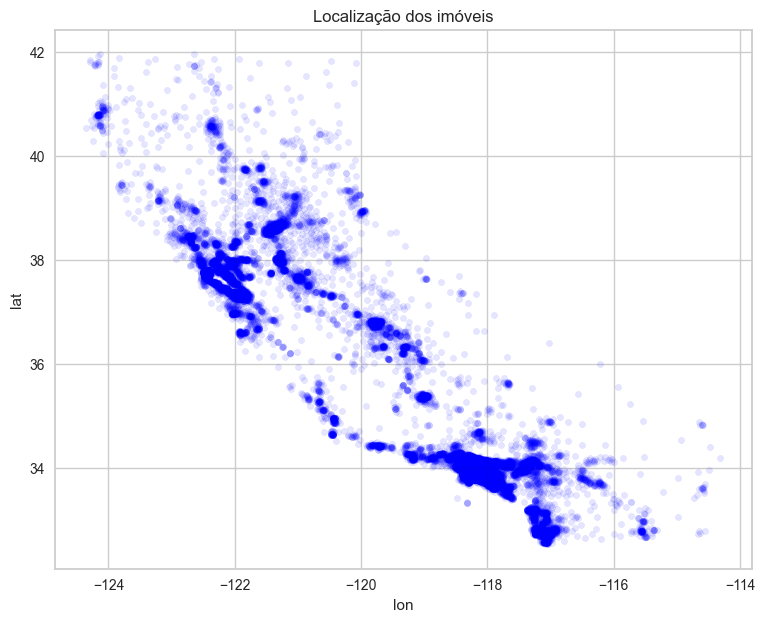

In [501]:
_ = housing.plot(kind="scatter", x="lon", y="lat", alpha=0.1, figsize=(9, 7), c='blue')
_ = plt.title('Localização dos imóveis')

Claramente os imóveis estão mais concentrados no litoral, onde são os grandes centros.

#### Quais são os efeitos da proximidade com o mar?

In [502]:
housing.groupby("ocean_proximity").housing_median_age.agg(mean_median_age='mean', median_median_age='median', std_median_age = 'std', max_median_age = 'max', min_median_age = 'min').reset_index().sort_values(by='mean_median_age')

,ocean_proximity,mean_median_age,median_median_age,std_median_age,max_median_age,min_median_age
1,INLAND,24.271867,23.0,12.018020,52.0,1.0
0,<1H OCEAN,29.279225,30.0,11.644453,52.0,2.0
4,NEAR OCEAN,29.347254,29.0,11.840371,52.0,2.0
3,NEAR BAY,37.730131,39.0,13.070385,52.0,2.0
2,ISLAND,42.400000,52.0,13.164346,52.0,27.0


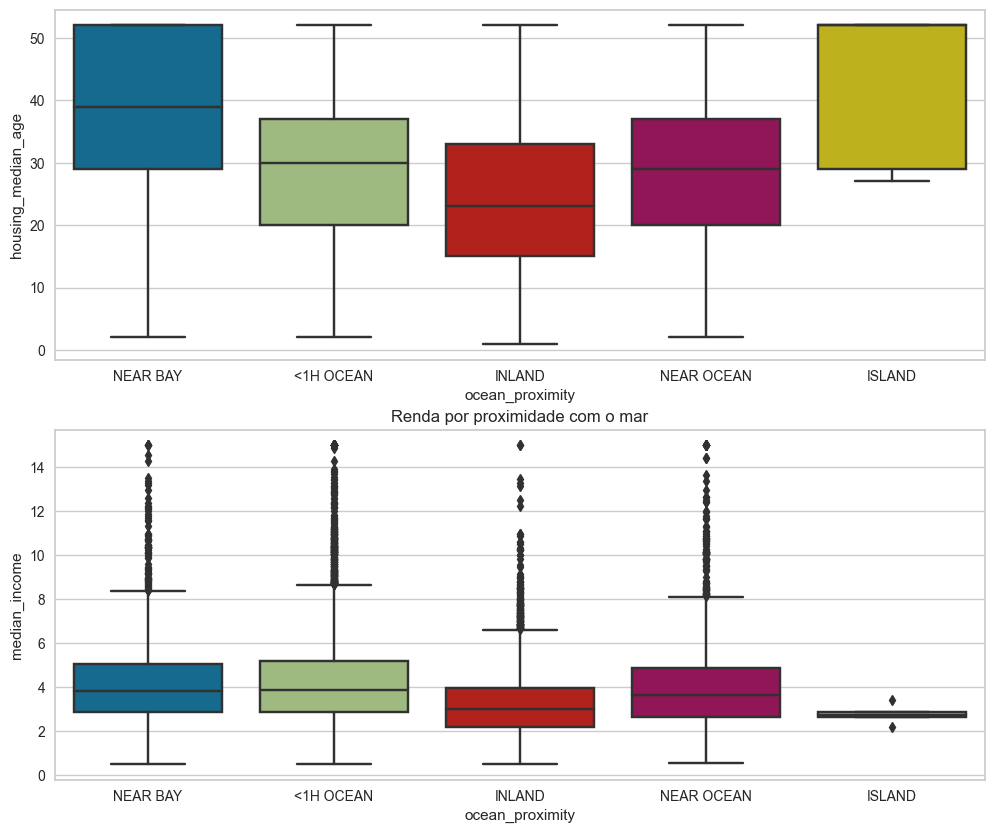

In [503]:
fig, axes = plt.subplots(2, figsize=(12,10))
axes = axes.flatten()

_ = sns.boxplot(data=housing, x='ocean_proximity', y='housing_median_age', ax=axes[0])
_ = sns.boxplot(data=housing, x='ocean_proximity', y='median_income', ax=axes[1])
_= plt.title('Renda por proximidade com o mar')

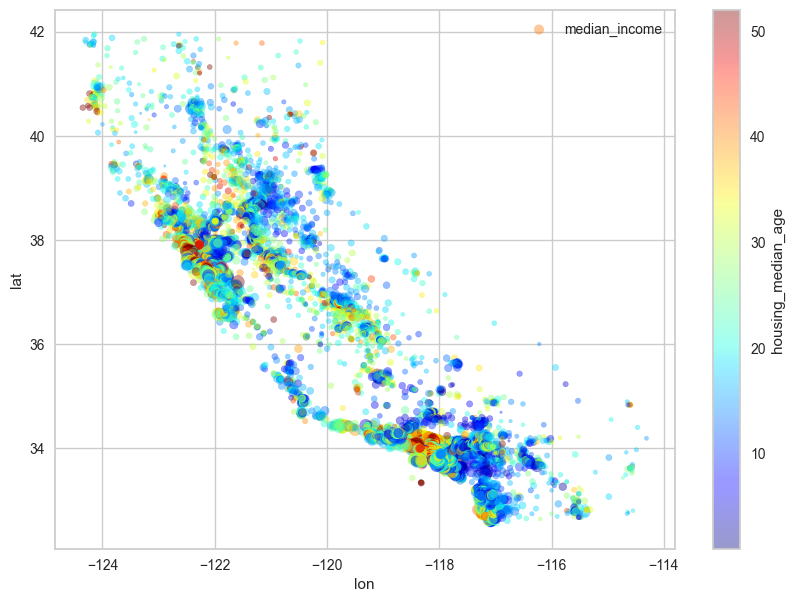

In [504]:
_ = housing.plot(kind="scatter", x="lon", y="lat", alpha=0.4, label="median_income", figsize=(10,7), 
        c="housing_median_age",s=housing.median_income*6, cmap=plt.get_cmap("jet"), colorbar=True)
_ = plt.legend()

Imóveis mais antigos situados perto do mar. Se parar para refletir é muito comum construções mas antigas se situarem no litoral.

Além disso viver no litoral custa mais caro, necessitando de uma renda maior.

In [505]:
housing.groupby('ocean_proximity').agg(
    {'households': ['mean', 'median', 'std', 'sum'],
     'population': ['mean', 'median', 'std', 'sum']}
)

households                                 population  \
                       mean median         std        sum         mean   
ocean_proximity                                                          
<1H OCEAN        517.744965  421.0  392.280718  4730118.0  1520.290499   
INLAND           477.447565  385.0  392.252095  3127759.0  1391.046252   
ISLAND           276.600000  288.0  113.200265     1383.0   668.000000   
NEAR BAY         488.616157  406.0  350.598369  1118931.0  1230.317467   
NEAR OCEAN       501.244545  429.0  344.445256  1332308.0  1354.008653   

                                                  
                 median          std         sum  
ocean_proximity                                   
<1H OCEAN        1247.0  1185.848357  13889374.0  
INLAND           1124.0  1168.670126   9112744.0  
ISLAND            733.0   301.691067      3340.0  
NEAR BAY         1033.5   885.899035   2817427.0  
NEAR OCEAN       1136.5  1005.563166   3598955.0

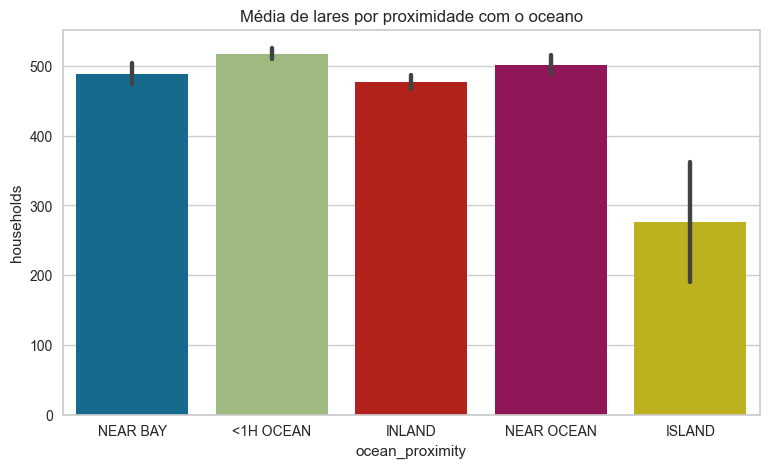

In [506]:
f = plt.figure(figsize=(9, 5))
_ = sns.barplot(data=housing, x='ocean_proximity', y='households')
_ = plt.title('Média de lares por proximidade com o oceano')

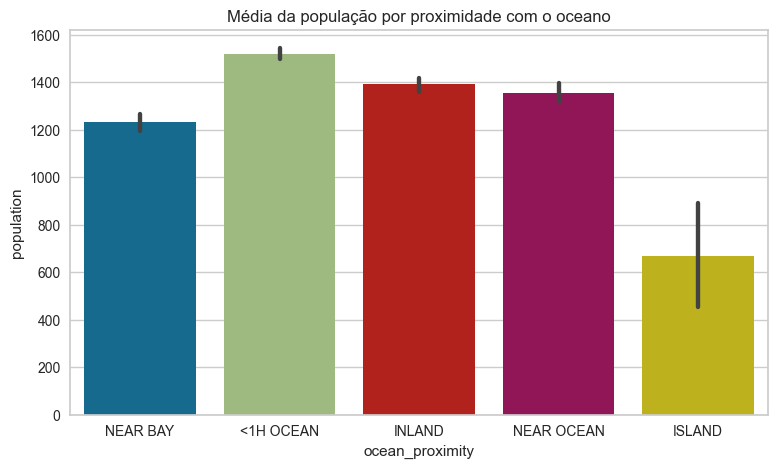

In [507]:
f = plt.figure(figsize=(9, 5))
_ = sns.barplot(data=housing, x='ocean_proximity', y='population')
_ = plt.title('Média da população por proximidade com o oceano')

## **Análise do valor mediano dos imóveis (alvo)**
#### Quais atributos se relacionam com o nosso alvo?
----------------------------------------------------------------

#### Será que a proximidade com o oceano influencia o valor do imóvel?

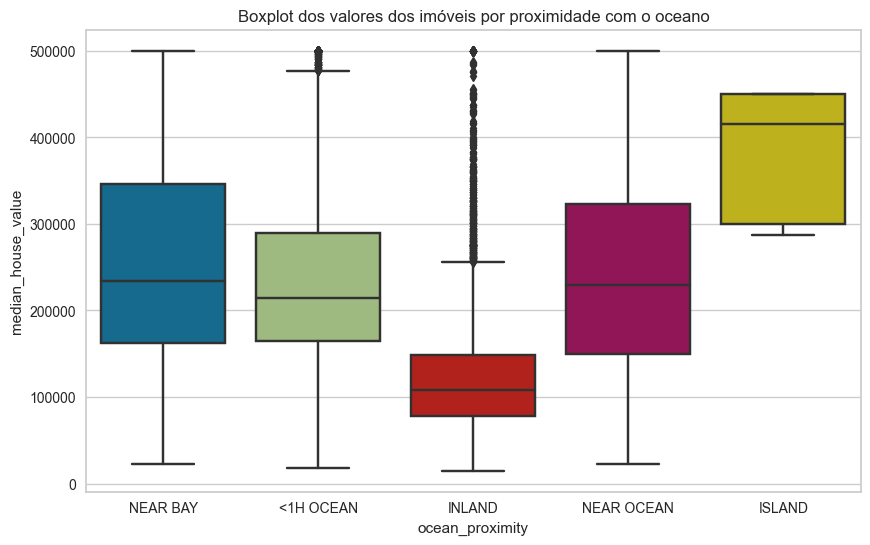

In [508]:
f = plt.figure(figsize=(10,6))
_ = sns.boxplot(data=housing, x='ocean_proximity', y='median_house_value')
_ = plt.title('Boxplot dos valores dos imóveis por proximidade com o oceano')

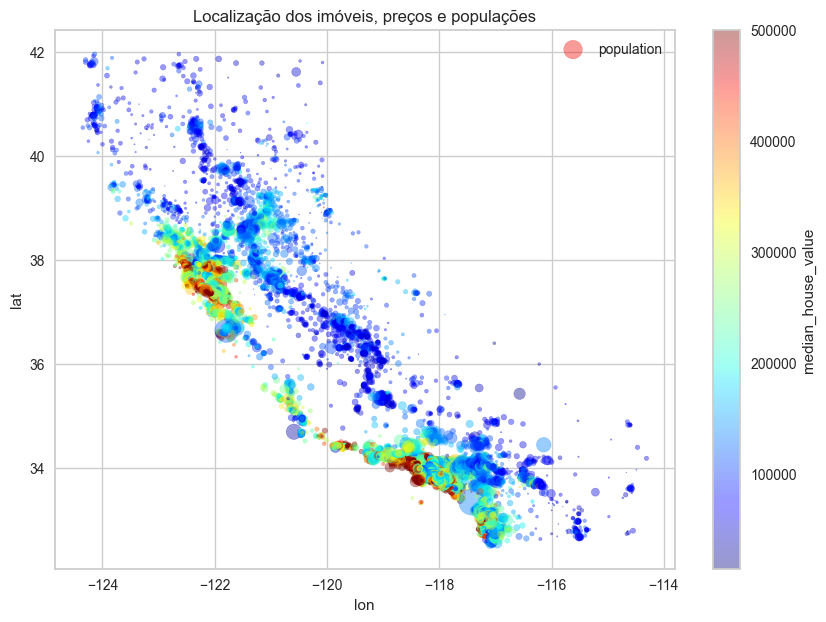

In [509]:
_ = housing.plot(kind="scatter", x="lon", y="lat", alpha=0.4,     
        s=housing["population"]/100, label="population", figsize=(10,7), 
        c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
_ = plt.title('Localização dos imóveis, preços e populações')
_ = plt.legend()

No litoral os imóveis são mais caros. Os centros ficam normalmente situados no litoral (como a cidade de Los Angeles) e nos centros há mais pessoas em busca de moradias, o que aumenta o valor delas.

#### Existe uma relação entre renda e o preço do imóvel?

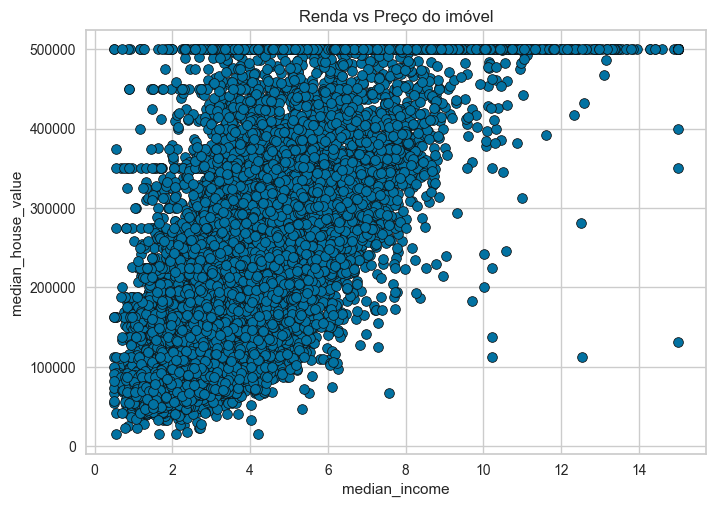

In [510]:
_ = sns.scatterplot(data=housing, x='median_income', y='median_house_value', edgecolor='k')
_ = plt.title('Renda vs Preço do imóvel')

Parece haver uma relação positiva entre as *features*. É possível observar também o limite em 500 mil no valor do imóvel apontado anteriormente.

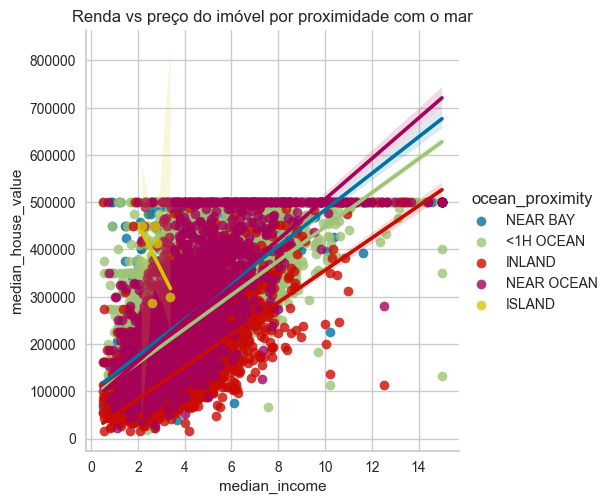

In [511]:
_ = sns.lmplot(data=housing, x='median_income', y='median_house_value', hue='ocean_proximity')
_ = plt.title('Renda vs preço do imóvel por proximidade com o mar')

Quanto mais perto do litoral, maior a inclinação da reta.

#### Existe uma relação entre a população e o valor do imóvel?

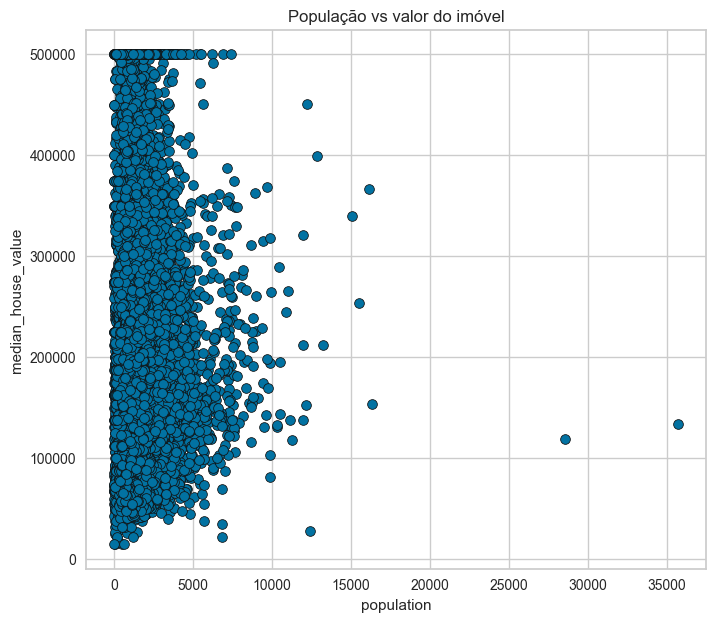

In [512]:
_ = plt.figure(figsize=(8,7))
_ = sns.scatterplot(data=housing, x='population', y='median_house_value', edgecolor='k')
_ = plt.title('População vs valor do imóvel')

Não parece existir uma relação entre população da localidade e o valor do imóvel.

## **Feature Engineering**
#### Adicionando novas features: distância ao oceano, cidade mais próxima e outros.
----------------------------------------------------------------

Para melhorar a qualidade da informação, vamos obter a **distância da habitação ao oceano** com as coordenadas da habitação e a linha do litoral. Vamos também calcular a **cidade mais próxima** daquela localidade (centro da cidade) e a **distância para o centro da cidade**. Além disso vamos adicionar outras informações como **número de quartos por famílias**, **numero de pessoas por família** e **número de quartos de dormir por quarto**.

In [513]:
import geopandas as gpd
import contextily as ctx

CRS='EPSG:4326'

# aqui estou transformando as coordenadas em pontos que o geopandas consegue ler
geometry_housing = gpd.points_from_xy(housing['lon'], housing['lat'])
points_housing = gpd.GeoDataFrame(housing)
points_housing = points_housing.set_geometry(geometry_housing)
points_housing.set_crs(CRS, inplace=True)

print(points_housing.crs)
points_housing.head(5)

EPSG:4326


,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-122.23000 37.88000)
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,POINT (-122.22000 37.86000)
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,POINT (-122.24000 37.85000)
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,POINT (-122.25000 37.85000)
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,POINT (-122.25000 37.85000)


### Distância ao oceano

Para calcular a distância do imóvel ao litoral, primeiro baixei os dados geográficos do litoral oeste dos Estados Unidos e com a biblioteca `GeoPandas` calculei a distância partindo de cada coordenada do *dataset*.

In [514]:
coastline = gpd.read_file('data/coastline/US_Westcoast.shp')[['geometry']]

# transformando no sistema de coordenadas global
coastline.to_crs(CRS, inplace=True)
coastline.head(5)

,geometry
0,"LINESTRING (-121.74192 36.20770, -121.74058 36..."
1,"LINESTRING (-121.54138 36.01699, -121.54364 36..."
2,"LINESTRING (-121.46864 35.92556, -121.46909 35..."
3,"LINESTRING (-121.46864 35.92556, -121.46864 35..."
4,"LINESTRING (-121.01394 35.46982, -121.01484 35..."


In [515]:
DISTANCE_CRS = 32643
nearest_coastline = gpd.sjoin_nearest(points_housing.to_crs(crs=DISTANCE_CRS), coastline.to_crs(crs=DISTANCE_CRS), distance_col = 'distance_to_ocean')
nearest_coastline.to_crs(CRS, inplace=True)
nearest_coastline = nearest_coastline[~nearest_coastline.index.duplicated(keep='first')]
nearest_coastline

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,index_right,distance_to_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (-122.23000 37.88000),3096,6979.824209
395,-122.34,37.88,37.0,3061.0,930.0,2556.0,924.0,1.7375,350000.0,NEAR BAY,POINT (-122.34000 37.88000),3096,1442.963258
397,-122.29,37.88,50.0,1211.0,261.0,523.0,227.0,3.8672,216700.0,NEAR BAY,POINT (-122.29000 37.88000),3096,1887.760426
400,-122.28,37.88,52.0,1844.0,332.0,769.0,334.0,4.2614,261300.0,NEAR BAY,POINT (-122.28000 37.88000),3096,2753.152754
423,-122.26,37.88,52.0,2551.0,417.0,894.0,404.0,6.2425,391800.0,NEAR BAY,POINT (-122.26000 37.88000),3096,4468.633182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,-121.77,38.76,32.0,1950.0,385.0,1145.0,363.0,2.8365,87900.0,INLAND,POINT (-121.77000 38.76000),1637,5129.957305
20584,-121.95,38.65,19.0,1265.0,228.0,755.0,218.0,3.3472,69800.0,INLAND,POINT (-121.95000 38.65000),1637,25413.196515
20575,-121.90,38.72,38.0,575.0,107.0,259.0,109.0,3.7500,187500.0,INLAND,POINT (-121.90000 38.72000),1627,17133.741710
20580,-121.77,38.76,32.0,1950.0,385.0,1145.0,363.0,2.8365,87900.0,INLAND,POINT (-121.77000 38.76000),1627,5129.957305


In [516]:
points_housing = nearest_coastline.drop(columns=['index_right'])

In [517]:
# checando valores nulos
get_na(points_housing[['distance_to_ocean']])

,distance_to_ocean


### Cidade mais próxima

Primeiramente baixei um arquivo .csv em que tem as coordenadas geográficas de cidades da Califórnia. Depois performei um *join* com as coordenadas dos imóveis e obtive as cidades mais próximas da localidade.

In [518]:
california_cities = pd.read_csv('app/utils/cal_cities_lat_long.csv')
california_cities.head(5)

,Name,Latitude,Longitude
0,Adelanto,34.582769,-117.409214
1,Agoura Hills,34.153339,-118.761675
2,Alameda,37.765206,-122.241636
3,Albany,37.886869,-122.297747
4,Alhambra,34.095286,-118.127014


In [519]:
# lendo as coordenadas a partir de longitude (x) e latitude (y) e transformando em pontos.
geometry_cal = gpd.points_from_xy(california_cities['Longitude'], california_cities['Latitude'])

# criando um dataframe a partir desses pontos
points_cal = gpd.GeoDataFrame(california_cities, geometry=geometry_cal)
points_cal.set_crs(CRS, inplace=True)

,Name,Latitude,Longitude,geometry
0,Adelanto,34.582769,-117.409214,POINT (-117.40921 34.58277)
1,Agoura Hills,34.153339,-118.761675,POINT (-118.76167 34.15334)
2,Alameda,37.765206,-122.241636,POINT (-122.24164 37.76521)
3,Albany,37.886869,-122.297747,POINT (-122.29775 37.88687)
4,Alhambra,34.095286,-118.127014,POINT (-118.12701 34.09529)
...,...,...,...,...
454,Woodland,38.678517,-121.773297,POINT (-121.77330 38.67852)
455,Yorba Linda,33.888625,-117.813111,POINT (-117.81311 33.88862)
456,Yreka,41.735419,-122.634472,POINT (-122.63447 41.73542)
457,Yuba City,39.140447,-121.616911,POINT (-121.61691 39.14045)


In [570]:
# performando o join para cruzar as coordenadas
joined_data = gpd.sjoin_nearest(points_housing.to_crs(DISTANCE_CRS),points_cal.to_crs(DISTANCE_CRS), how='left', distance_col='distance_nearest_city')
joined_data = joined_data[~joined_data.index.duplicated(keep='first')]
joined_data.head(5)

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,geometry,distance_to_ocean,index_right,Name,Latitude,Longitude,distance_nearest_city
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,POINT (2020652.780 15660597.373),6979.824209,34,Berkeley,37.871592,-122.272747,3984.556985
395,-122.34,37.88,37.0,3061.0,930.0,2556.0,924.0,1.7375,350000.0,NEAR BAY,POINT (2030427.938 15658729.211),1442.963258,3,Albany,37.886869,-122.297747,3902.600127
397,-122.29,37.88,50.0,1211.0,261.0,523.0,227.0,3.8672,216700.0,NEAR BAY,POINT (2025984.537 15659579.972),1887.760426,3,Albany,37.886869,-122.297747,1051.680579
400,-122.28,37.88,52.0,1844.0,332.0,769.0,334.0,4.2614,261300.0,NEAR BAY,POINT (2025095.886 15659749.805),2753.152754,34,Berkeley,37.871592,-122.272747,1162.617657
423,-122.26,37.88,52.0,2551.0,417.0,894.0,404.0,6.2425,391800.0,NEAR BAY,POINT (2023318.614 15660089.151),4468.633182,34,Berkeley,37.871592,-122.272747,1500.334976


In [571]:
joined_data = joined_data.rename(columns={'Name': 'nearest_city'})
joined_housing=joined_data.drop(columns=['geometry','index_right','Latitude','Longitude'])

In [572]:
nulls = get_na(joined_housing)
nulls

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,distance_to_ocean,nearest_city,distance_nearest_city
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY,4802.850294,San Leandro,5154.986403
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY,3519.672502,San Leandro,3126.488839
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY,998.779672,Oakland,2895.257153
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY,78.745648,Alameda,1741.902378
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY,5300.889258,Hayward,2978.468130
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18873,-122.22,38.08,37.0,2811.0,NaN,1574.0,516.0,3.1053,96700.0,NEAR BAY,1642.780805,Vallejo,4297.769732
19060,-122.41,38.16,37.0,1549.0,NaN,863.0,275.0,2.7457,254700.0,NEAR BAY,51.530799,American Canyon,13552.233934
19332,-122.91,38.46,18.0,2021.0,NaN,912.0,329.0,4.5000,251900.0,<1H OCEAN,17795.961272,Sebastopol,10185.167922
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN,3775.352066,Oxnard,1250.537614


In [573]:
if nulls.total_bedrooms.isna().all():
    print("-> Os valores nulos estão na coluna 'total_bedrooms'.")
if not nulls.nearest_city.isna().any():
    print("\n-> Não há valores nulos na coluna 'nearest city'.")

-> Os valores nulos estão na coluna 'total_bedrooms'.

-> Não há valores nulos na coluna 'nearest city'.


É possível ver que há uma relação, **quanto menor a distância maior o valor da casa em média**. Quando as distâncias são próximas os preços ficam mais **flutuantes**, indicando que a variável não tem mais tanta relação e que **é necessário outras variáveis**.

### Outros

In [574]:
copy = joined_housing.copy()

copy['rooms_per_household'] = copy.total_rooms / copy.households
copy['population_per_household'] = copy.population / copy.households
copy['bedrooms_per_room'] = copy.total_bedrooms / copy.total_rooms

## **Explorando as novas variáveis**
#### Entendendo como se comportam nossas novas variáveis e explorando-as.
----------------------------------------------------------------

### Cidade mais próxima

In [575]:
copy.nearest_city.value_counts()

San Francisco    439
San Diego        365
San Fernando     351
Los Angeles      311
Sacramento       274
                ... 
Mount Shasta       3
Tulelake           2
Amador City        1
Dorris             1
Fort Jones         1
Name: nearest_city, Length: 456, dtype: int64

In [576]:
groupby_nearest_city = copy.groupby('nearest_city').agg({"median_income":'median', "median_house_value":'median'}).sort_values(by='median_income')
groupby_nearest_city

,median_income,median_house_value
nearest_city,,
Dorris,1.74000,44000.0
Calipatria,1.77270,50000.0
Vernon,1.81250,112500.0
Delano,1.81440,59800.0
Mendota,1.85905,56600.0
...,...,...
Malibu,7.91840,500001.0
Saratoga,8.03310,500001.0
Palos Verdes Estates,8.08975,500001.0


In [577]:
groupby_nearest_city.corr()

,median_income,median_house_value
median_income,1.000000,0.837038
median_house_value,0.837038,1.000000


In [578]:
higher_price_cities = copy.groupby('nearest_city').median_house_value.mean().nlargest(30)
higher_price_cities.plot(kind='bar', backend='plotly', title='Preços dos 30 imóveis mais caros e sua cidade mais próxima')

### Distância até o mar

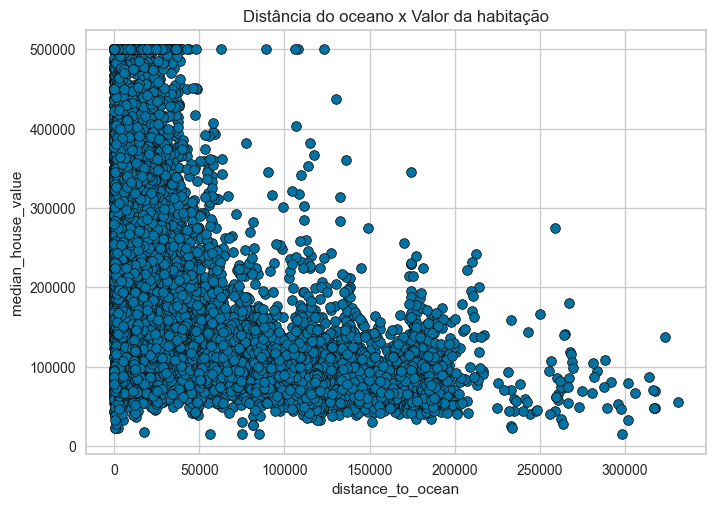

In [579]:
_ = sns.scatterplot(data=copy, x='distance_to_ocean', 
                    y='median_house_value', edgecolor='k')
_ = plt.title('Distância do oceano x Valor da habitação')

<AxesSubplot:xlabel='lon', ylabel='lat'>

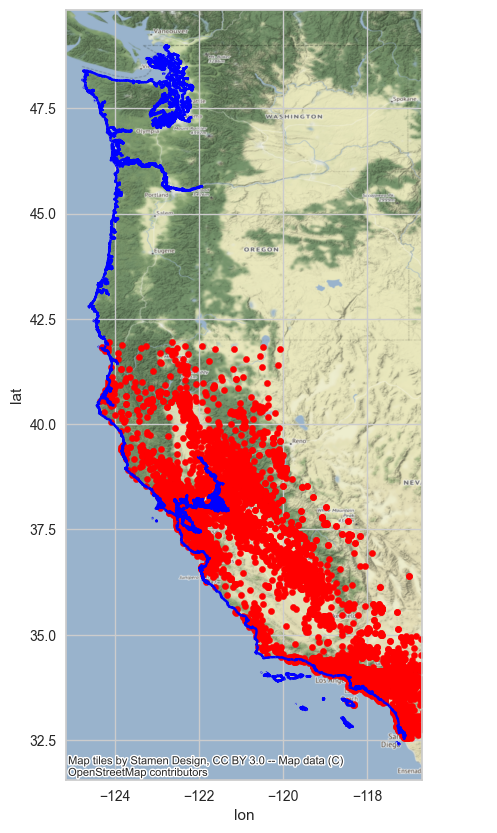

In [530]:
coastline.to_crs(CRS, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
coastline.plot(ax=ax, color='blue')
ctx.add_basemap(ax=ax, crs=coastline.crs.to_string(), source=ctx.providers.Stamen.Terrain)
copy.plot(ax=ax, x='lon', y='lat', color='red', kind='scatter')

A costa se estende até pontos em que, possivelmente, são classificados como **"INLAND"**.

### Correlações

In [580]:
copy.select_dtypes(include=np.number).corr()['median_house_value']

lon                        -0.045967
lat                        -0.144160
housing_median_age          0.105623
total_rooms                 0.134153
total_bedrooms              0.049686
population                 -0.024650
households                  0.065843
median_income               0.688075
median_house_value          1.000000
distance_to_ocean          -0.432255
distance_nearest_city      -0.140791
rooms_per_household         0.151948
population_per_household   -0.023737
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

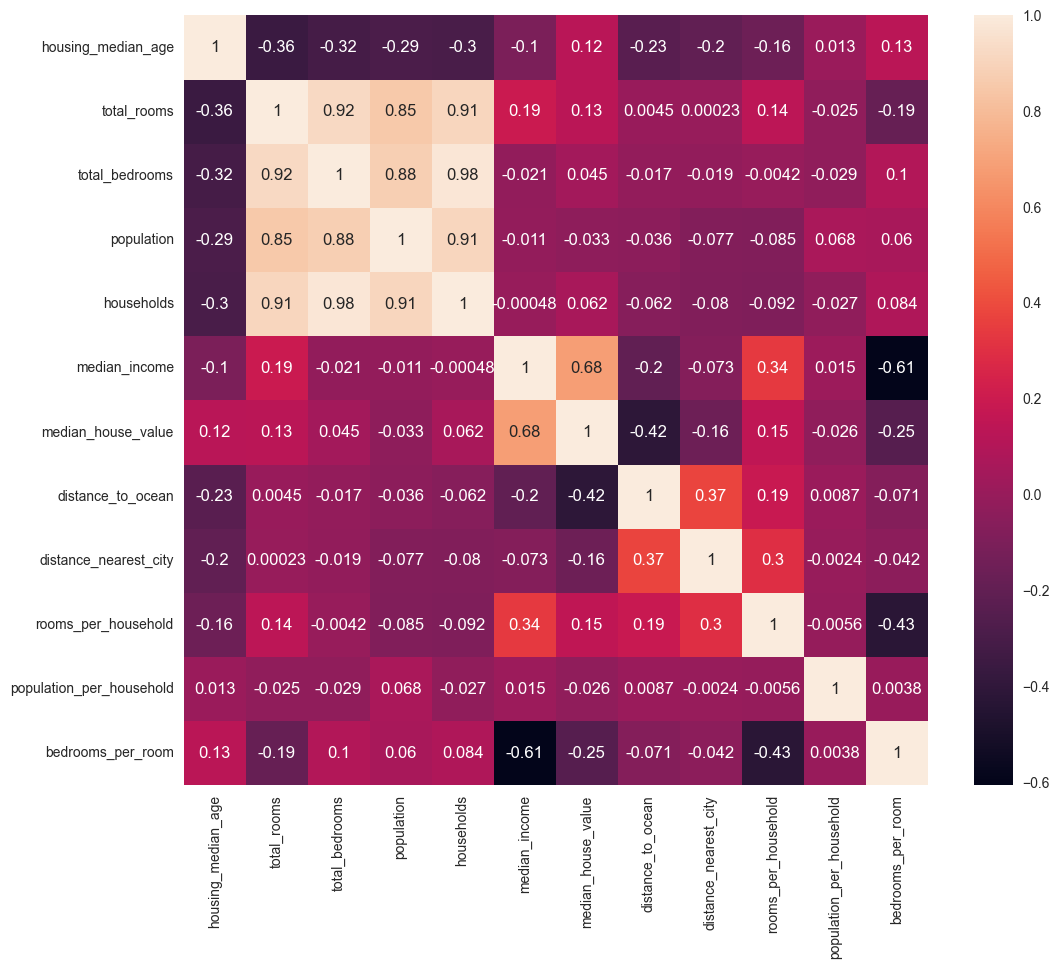

In [532]:
_ = plt.figure(figsize=(12, 10))
_ = sns.heatmap(copy.drop(columns=['lat','lon']).select_dtypes('number').corr(), annot=True)

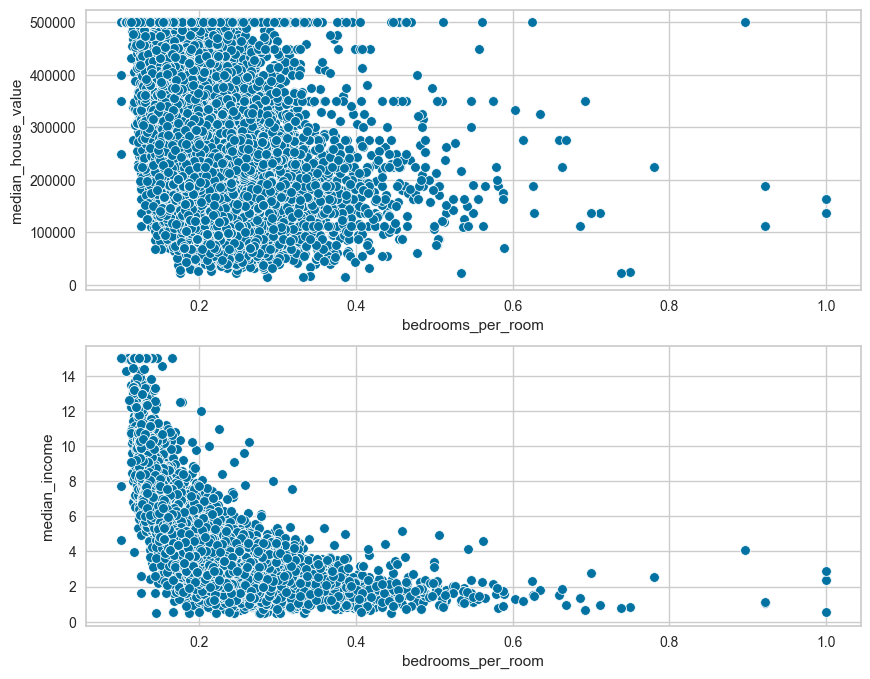

In [533]:
fig, axes = plt.subplots(2, figsize=(10,8))

_ = sns.scatterplot(data=copy, x='bedrooms_per_room', y='median_house_value', ax = axes[0])
_ = sns.scatterplot(data=copy, x='bedrooms_per_room', y='median_income', ax=axes[1])

Parece haver uma relação **não-linear** no segundo gráfico, porém um ajuste linear creio que será suficiente.

## **Preparando para a modelagem**
#### Organização e limpeza dos dados
----------------------------------------------------------------

Vamos utilizar o objeto `Pipeline` do scikit-learn para aplicar preenchimento de *missing*, criar as novas variáveis, treinar e validar o modelo. O objetivo é deixar o código mais limpo e organizado, além de, claro, [evitar *data leakage*](https://www.linkedin.com/posts/andreyukio_pipeline-ugcPost-7051884985586266112-L1zq?utm_source=share&utm_medium=member_desktop).

In [84]:
data = pd.read_csv('data/housing.csv').rename(columns={"longitude":'lon',
                                                       "latitude": 'lat'})

# filtrando os preços para que a regressão linear não aprenda que existe um falso limite em 500 mil.
data = data.query("median_house_value < 500_000")

X_data = data.drop(columns='median_house_value')
y = data['median_house_value']

In [85]:
data

,lon,lat,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.25, random_state=42)

### Feature Selection

- Aqui vamos utilizar o `SmartCorrelatedSelection` para selecionar somente as features que não são altamente correlacionadas, por motivos de simplificação ao entrar com os dados no app.

In [87]:
corr_sel = SmartCorrelatedSelection(threshold=0.9, method='pearson')

- Além disso vamos importar nosso *transformer* personalizado, baseado na seção de *feature engineering*. O *transformer* está no arquivo `app/utils/combiner.py`.

In [99]:
# importando trasnformer personalizado
%autoreload 2
from app.utils.combiner import CombinedAttributesAdder

feature_sel_pipe = Pipeline(
    steps=[
        ('corr_sel', corr_sel)
        ]
)

feature_eng = Pipeline(
    steps=[
        ('attr_combiner', CombinedAttributesAdder(add_bedrooms_per_room=True))]
)

In [100]:
result = feature_eng.fit_transform(X_train, y=y_train)
result = feature_sel_pipe.fit_transform(result, y=y_train)
selected_columns = result.columns
cat_columns = ["nearest_city"]
num_columns = selected_columns.drop(cat_columns).to_list()
print(f"Variáveis numéricas utilizadas: {num_columns}")
print(f"Variáveis categóricas utilizadas: {cat_columns}")

Variáveis numéricas utilizadas: ['housing_median_age', 'total_rooms', 'population', 'median_income', 'ocean_proximity', 'distance_nearest_city', 'rooms_per_household', 'bedrooms_per_room']
Variáveis categóricas utilizadas: ['nearest_city']


In [101]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

imp = SimpleImputer()

num_data = result.select_dtypes('number')
num_data = pd.DataFrame(imp.fit_transform(num_data), columns = num_data.columns)

vif_data = pd.DataFrame()
vif_data["feature"] = num_data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(num_data.values, i)
                          for i in range(len(num_data.columns))]
  
print(vif_data)

                 feature        VIF
0     housing_median_age   6.431808
1            total_rooms  13.570624
2             population  13.845824
3          median_income   6.331089
4  distance_nearest_city   1.758071
5    rooms_per_household   7.402766
6      bedrooms_per_room   9.384196


In [102]:
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer()),
        ('scaler', StandardScaler())
    ])  

cat_pipeline = Pipeline(
    steps=[
        ('encoder', OneHotEncoder(handle_unknown="ignore"))
    ])

preprocessor = ColumnTransformer(transformers=[
    ("num_pipe", num_pipeline, make_column_selector(dtype_include='number',)),
    ("cat_pipe", cat_pipeline, make_column_selector(dtype_include=object))
])

In [103]:
reg = Pipeline(
    steps=[
        ('feat_eng', feature_eng),
        ('feat_selection', feature_sel_pipe),
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())]
)

## Treinamento e validação do modelo
---------------------------------------------------------------

In [104]:
reg.fit(X_train, y=y_train)

Pipeline(steps=[('feat_eng',
                 Pipeline(steps=[('attr_combiner',
                                  CombinedAttributesAdder())])),
                ('feat_selection',
                 Pipeline(steps=[('corr_sel',
                                  SmartCorrelatedSelection(threshold=0.9))])),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019E2FD77910>),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000019E2FD77F40>)])),
                ('regressor', LinearRegression())])

In [105]:
reg.score(X_test, y_test)

0.7534297800692404

### Resultados e performance

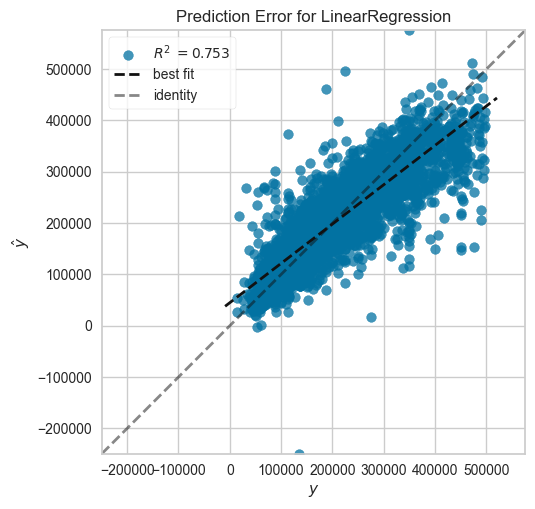

In [107]:
from yellowbrick.regressor import prediction_error

visualizer = prediction_error(reg, X_train, y_train, X_test, y_test)
_ = visualizer.show()

In [108]:
rmse_scores = cross_val_score(reg, X_train, y_train, cv=6, scoring='neg_root_mean_squared_error')
rmse_mean_error = -rmse_scores.mean()
rmse_std_error = rmse_scores.std()

print(f"Erro médio de {rmse_mean_error:.2f} com desvio padrão de {rmse_std_error:.2f}")

Erro médio de 46916.87 com desvio padrão de 1233.83


#### Algumas considerações:
- Obtivemos um **erro médio** razoável dado os atributos fornecidos e considerando o fato do *dataset* ser relativamente antigo.
- Não foi efetuado uma seleção inteligente de modelos para obter o modelo de melhor performance, foi utilizada somente a regressão linear múltipla.

In [109]:
# saving the model
import pickle
pickle.dump(reg, open('app/model/linear_reg_model.pkl', 'wb'))